# Hamiltonian Solver Function

Rename n_svn0 to p_e (probability of emission)

In [ ]:
# Simulate SnV center coupled to a diamond cavity mode m_sig with Q=Q_sig.
# m_sig couples to m_idl with Q=Q_idl.

from qutip import *
import numpy as np
import matplotlib.pyplot as plt

def get_spectral_efficiency(g, J, kappa_sig, kappa_idl, sim_time=100e-9, kappa_emitter=0, plot=True, ntraj=0, target_tol=1e-3):
    """
    Returns how much light is dissipated into the idler
    Args:
        g: emitter decay rate
        J: coupling between signal and idler
        kappa_sig: decay rate from signal mode
        kappa_idl: decay rate from idler mode
        kappa_emitter: decay rate from emitter mode
    """
    N_sig = 2  # Truncation for m_sig Fock space
    N_idl = 2  # Truncation for m_idl Fock space

    # Operators
    a_sig = tensor(destroy(N_sig), qeye(N_idl), qeye(2))
    a_idl = tensor(qeye(N_sig), destroy(N_idl), qeye(2))
    sm    = tensor(qeye(N_sig), qeye(N_idl), destroy(2))

    # Hamiltonian
    H = (
        # wc_sig * a_sig.dag() * a_sig +
        # wc_idl * a_idl.dag() * a_idl +
        # wsnv * sm.dag() * sm +
        g * (a_sig.dag() * sm + a_sig * sm.dag()) +
        J * (a_sig.dag() * a_idl + a_sig * a_idl.dag())
    )

    # Collapse operators for cavity losses
    c_ops = []
    if kappa_sig > 0:
        c_ops.append(np.sqrt(kappa_sig) * a_sig)
    if kappa_idl > 0:
        c_ops.append(np.sqrt(kappa_idl) * a_idl)
    if kappa_emitter > 0:
        c_ops.append(np.sqrt(kappa_emitter) * sm)

    # Initial state: SnV ground, m_sig empty, m_idl empty
    psi0 = tensor(basis(N_sig,0), basis(N_idl,0), basis(2,1))

    # Time
    tlist = np.linspace(0, sim_time, 1001)  # ns simulation

    # Solve
    if ntraj == 0:
        result = mesolve(H, psi0, tlist, c_ops, [a_sig.dag()*a_sig, a_idl.dag()*a_idl, sm.dag()*sm], options={'nsteps': 1e5})
    else:
        result = mcsolve(H, psi0, tlist, c_ops, [a_sig.dag()*a_sig, a_idl.dag()*a_idl, sm.dag()*sm], options={'nsteps': 1e5, 'progress_bar': False}, ntraj=ntraj, target_tol=target_tol)

    # Extract expectation values
    n_sig0 = result.expect[0]
    n_idl0 = result.expect[1]
    n_snv0 = result.expect[2]


    sig0_emission_rate = n_sig0*kappa_sig
    idl0_emission_rate = n_idl0*kappa_idl
    snv0_emission_rate = n_snv0*kappa_emitter

    # integrate n_sig and n_idl
    eff_sig_int = np.trapezoid(sig0_emission_rate, tlist)
    eff_idl_int = np.trapezoid(idl0_emission_rate, tlist)
    eff_snv_int = np.trapezoid(snv0_emission_rate, tlist)
    spectral_efficiency = eff_idl_int/(eff_sig_int+eff_idl_int+eff_snv_int)
    if plot:
        # Plot expectation values
        fit, axs = plt.subplots(1,2,  figsize=(10, 6))
        axs[0].plot(tlist * 1e9, n_sig0, label='⟨n_sig⟩')
        axs[0].plot(tlist * 1e9, n_idl0, label='⟨n_idl⟩')
        axs[0].plot(tlist * 1e9, n_snv0, label='⟨n_SnV⟩ (excited)')
        axs[0].set_xlabel('Time (ns)')
        axs[0].set_ylabel('Expectation value')
        axs[0].legend()
        axs[0].set_title('Time Evolution of Expectation Values')
        axs[1].plot(tlist * 1e9, sig0_emission_rate, label='signal')
        axs[1].plot(tlist * 1e9, idl0_emission_rate, label='idler')
        if kappa_emitter > 0:
            axs[1].plot(tlist * 1e9, snv0_emission_rate, label='emitter (non-radiative)')
        axs[1].set_xlabel('Time (ns)')
        axs[1].set_ylabel('Emission rate')
        axs[1].legend()
        axs[1].set_title('Emission rates')

        plt.legend()
    return spectral_efficiency

# Master Equation Test

/home/floresh2/.conda/envs/zm/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


High Q Efficiency: 0.9377309182750341
Low Q Efficiency: 0.6029475812418077


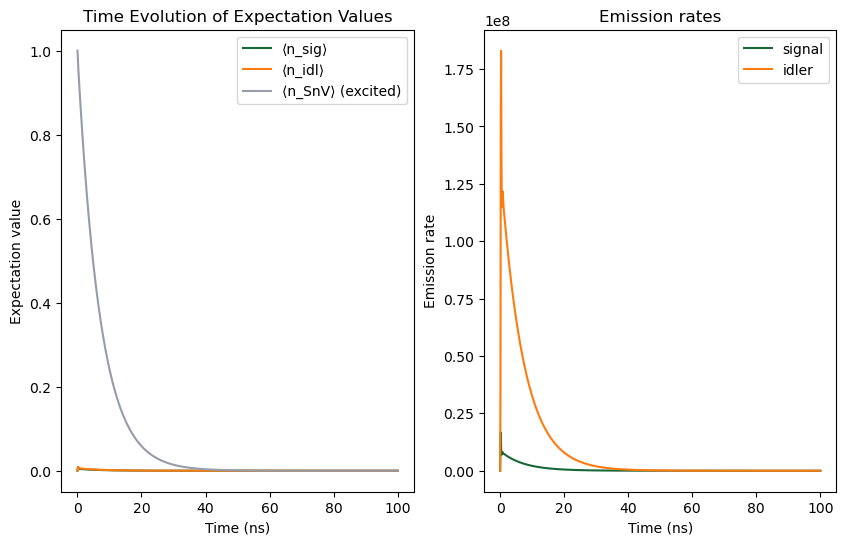

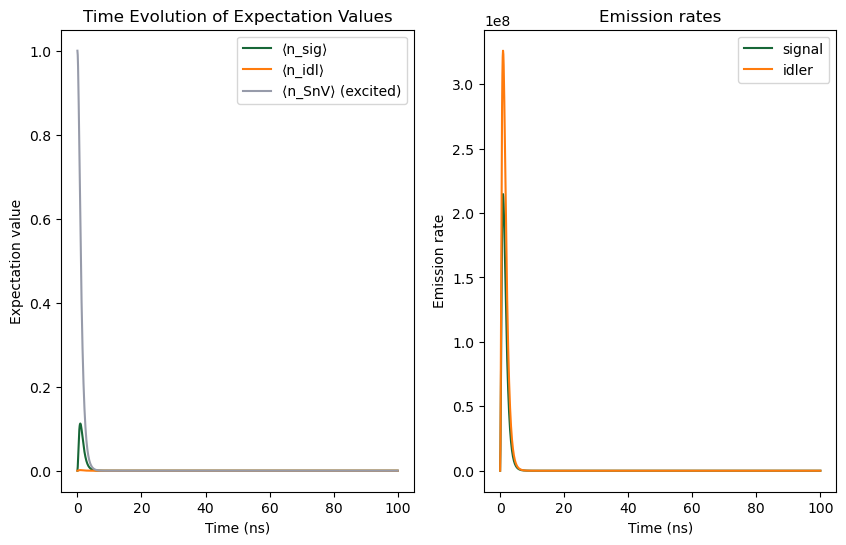

In [152]:

# Parameters
wc_sig = 2*np.pi*484e12 # Signal cavity frequency (Hz)
wc_idl = 2*np.pi*180e12 # Idler cavity frequency (Hz)
wsnv   = 2*np.pi*484e12 # SnV transition frequency (Hz)
emitter_lifetime = 6e-9 # (s)
g      = 2*np.pi/emitter_lifetime     # Coupling: SnV<->m_sig (Hz)
Q_sig = 1e7
Q_idl = 3.2644e5
kappa_sig = 2*np.pi*wc_sig/Q_sig  # Decay rate for m_sig from Q_sig
kappa_idl = 2*np.pi*wc_idl/Q_idl  # Decay rate for m_idl from Q_idl
J      = 2*np.pi*2e9   # Coupling: m_sig<->m_idl (Hz)

eta_highq = get_spectral_efficiency(g, J, kappa_sig, kappa_idl, plot=True)
kappa_idl *= 10
eta_lowq = get_spectral_efficiency(g, J, kappa_sig, kappa_idl, plot=True)

print(f'High Q Efficiency: {eta_highq}')
print(f'Low Q Efficiency: {eta_lowq}')


# Monte Carlo Test

/home/floresh2/.conda/envs/zm/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


High Q Efficiency: 0.937803974414943
Low Q Efficiency: 0.6008216146216663


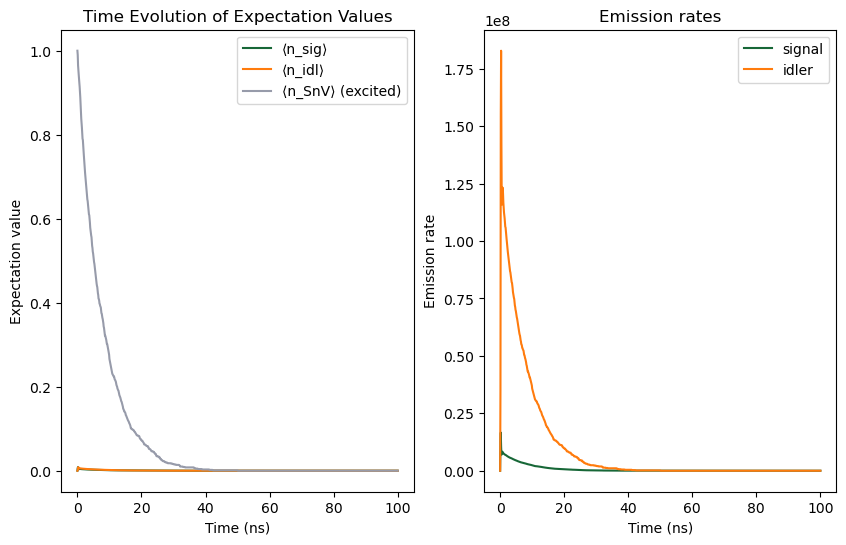

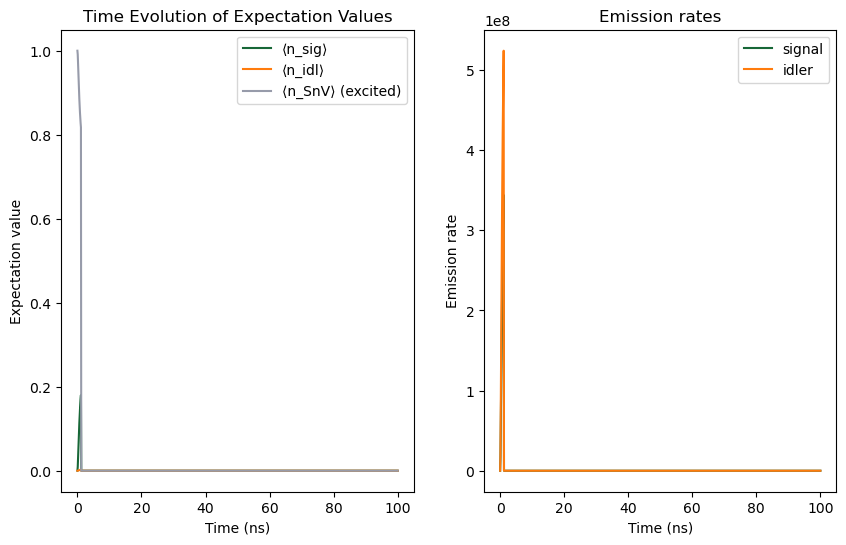

In [154]:

# Parameters
wc_sig = 2*np.pi*484e12 # Signal cavity frequency (Hz)
wc_idl = 2*np.pi*180e12 # Idler cavity frequency (Hz)
wsnv   = 2*np.pi*484e12 # SnV transition frequency (Hz)
emitter_lifetime = 6e-9 # (s)
g      = 2*np.pi/emitter_lifetime     # Coupling: SnV<->m_sig (Hz)
Q_sig = 1e7
Q_idl = 3.2644e5
kappa_sig = 2*np.pi*wc_sig/Q_sig  # Decay rate for m_sig from Q_sig
kappa_idl = 2*np.pi*wc_idl/Q_idl  # Decay rate for m_idl from Q_idl
J      = 2*np.pi*2e9   # Coupling: m_sig<->m_idl (Hz)

eta_highq = get_spectral_efficiency(g, J, kappa_sig, kappa_idl, plot=True, ntraj=1000, target_tol=1e-2)
kappa_idl *= 10
eta_lowq = get_spectral_efficiency(g, J, kappa_sig, kappa_idl, plot=True, ntraj=1000, target_tol=1e-2)

print(f'High Q Efficiency: {eta_highq}')
print(f'Low Q Efficiency: {eta_lowq}')


# Efficiency vs Q_idl

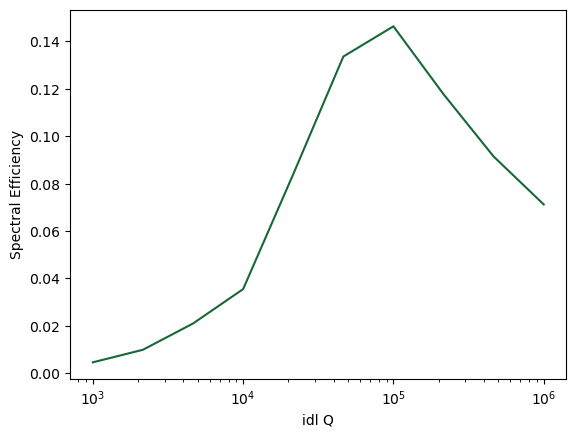

In [163]:

# Parameters
wc_sig = 2*np.pi*484e12 # Signal cavity frequency (Hz)
wc_idl = 2*np.pi*180e12 # Idler cavity frequency (Hz)
wsnv   = 2*np.pi*484e12 # SnV transition frequency (Hz)
emitter_lifetime = 6e-9 # (s)
g      = 2*np.pi/emitter_lifetime*50     # Coupling: SnV<->m_sig (Hz)
Q_sig = 1e6
Qs_idl = np.logspace(3, 6, 10)
kappa_sig = 2*np.pi*wc_sig/Q_sig  # Decay rate for m_sig from Q_sig
# kappa_idl = 2*np.pi*wc_idl/Q_idl  # Decay rate for m_idl from Q_idl

J      = 2*np.pi*2e9   # Coupling: m_sig<->m_idl (Hz)
effs = []
for Q_idl in Qs_idl:
    kappa_idl = 2*np.pi*wc_idl/Q_idl  # Decay rate for m_idl from Q_idl
    eff = get_spectral_efficiency(g, J, kappa_sig, kappa_idl, sim_time=5e-9, plot=False, ntraj=500, target_tol=1e-2)
    effs.append(eff)
    plt.show()
plt.figure()
plt.plot(Qs_idl, effs)
plt.xscale('log')
plt.xlabel('idl Q')
plt.ylabel('Spectral Efficiency')
plt.show()


In [ ]:

# Parameters
wc_sig = 2*np.pi*484e12 # Signal cavity frequency (Hz)
wc_idl = 2*np.pi*180e12 # Idler cavity frequency (Hz)
wsnv   = 2*np.pi*484e12 # SnV transition frequency (Hz)
emitter_lifetime = 6e-9 # (s)
g      = 2*np.pi/emitter_lifetime*50     # Coupling: SnV<->m_sig (Hz)
Q_sig = 1e6
Qs_idl = np.logspace(3, 6, 10)
kappa_sig = 2*np.pi*wc_sig/Q_sig  # Decay rate for m_sig from Q_sig
# kappa_idl = 2*np.pi*wc_idl/Q_idl  # Decay rate for m_idl from Q_idl

Js      = 2*np.pi*np.logspace(8, 10, 3)   # Coupling: m_sig<->m_idl (Hz)

effs = np.zeros((len(Js), len(Qs_idl)))
for i, J in enumerate(Js):
    for j, Q_idl in enumerate(Qs_idl):
        kappa_idl = 2*np.pi*wc_idl/Q_idl  # Decay rate for m_idl from Q_idl
        eff = get_spectral_efficiency(g, J, kappa_sig, kappa_idl, sim_time=5e-9, plot=False, ntraj=500, target_tol=1e-2)
        effs[i, j] = eff


plt.figure()
plt.pcolormesh(Qs_idl, Js, effs)
plt.xscale('log')
plt.xlabel('idl Q')
plt.ylabel('Coupling (Hz)')
plt.colorbar(label='Spectral Efficiency')
plt.show()


/home/floresh2/.conda/envs/zm/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


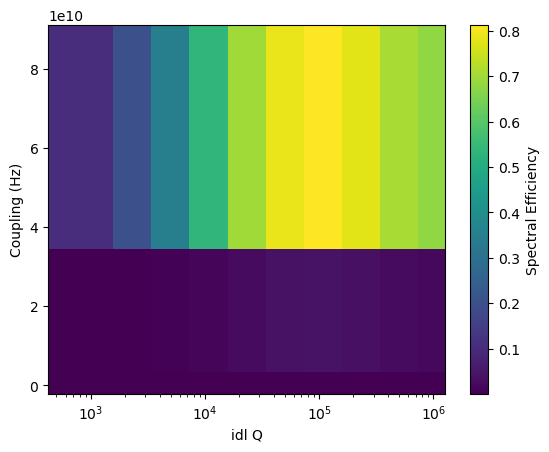

# Q=1e5 chi3 result

/home/floresh2/.conda/envs/zm/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


np.float64(0.9681424623326541)

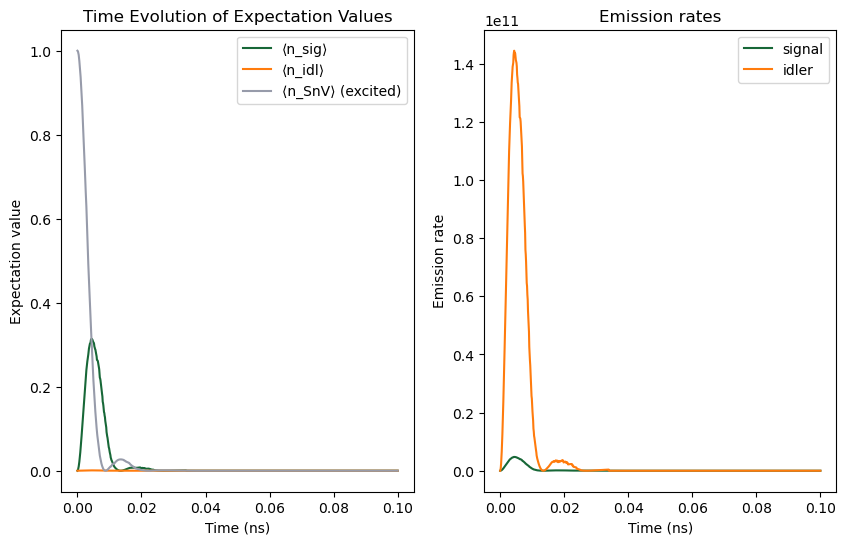

In [169]:
params = {
    'g': 261269176045.13147, 
    'kappa_sig': 15144165954.55432, 
    'kappa_idl': 1.74129082e+14, 
    'J': 4476515298596.386+0j
}

get_spectral_efficiency(**params, plot=True, sim_time=0.1e-9, ntraj=1000, target_tol=1e-2)